In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import math

init_notebook_mode(connected=True)

data_path_train = "res/AutoMPG.shuf.train.csv"
data_path_test = "res/AutoMPG.shuf.test.csv"
result_folder = "results/"

test_set_ratio=0.1

In [4]:
df_train = pd.read_csv(data_path_train)
df_test = pd.read_csv(data_path_test)
df_train.head(10) #199x10

,id,mpg,carName,cylinders,displacement,horsepower,weight,acceleration,modelYear,origin
0,37,19.0,ford torino 500,6,250.0,88,3302,15.5,71,1
1,312,32.1,chevrolet chevette,4,98.0,70,2120,15.5,80,1
2,29,9.0,hi 1200d,8,304.0,193,4732,18.5,70,1
3,330,44.6,honda civic 1500 gl,4,91.0,67,1850,13.8,80,3
4,71,13.0,chrysler newport royal,8,400.0,190,4422,12.5,72,1
5,38,18.0,amc matador,6,232.0,100,3288,15.5,71,1
6,280,29.5,honda accord lx,4,98.0,68,2135,16.6,78,3
7,68,11.0,mercury marquis,8,429.0,208,4633,11.0,72,1
8,308,26.8,oldsmobile omega brougham,6,173.0,115,2700,12.9,79,1
9,263,19.2,chevrolet monte carlo landau,8,305.0,145,3425,13.2,78,1


In [11]:
# overview over missing values
l_n_b = df_train.isnull().sum()>0
print(df_train.loc[:,l_n_b])
df_train.loc[:,l_n_b].isnull().sum()

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[199 rows x 0 columns]


Series([], dtype: float64)

In [12]:
# handle missing categorical values
cat_df_train = df_train.select_dtypes(include=['object']).copy()
cat_df_test = df_test.select_dtypes(include=['object']).copy()
#l_n_b = cat_df_train.isnull().sum()>0
#l_n_b_test = cat_df_test.isnull().sum()>0
# cat_df_data.loc[:,l_n_b].head(10) #only geocode2
#cat_df_data = cat_df_data.fillna('')
#cat_df_test = cat_df_test.fillna('')
# cat_df_data.loc[850:860,l_n_b]

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
cat_df_train = cat_df_train.apply(enc.fit_transform) # categorical values - one hot encoding (73 object columns)
cat_df_test = cat_df_test.apply(enc.fit_transform)
cat_df_train.head(5)

,carName,horsepower
0,90,63
1,29,48
2,91,29
3,97,45
4,43,28


In [14]:
# handle missing numerical values
#from sklearn.preprocessing import Imputer
df_train_num = df_train.select_dtypes(include=['int64','float64'])
df_train_num = df_train_num.fillna(df_train_num.mean())

df_test_num = df_test.select_dtypes(include=['int64','float64'])
df_test_num = df_test_num.fillna(df_test_num.mean())

In [16]:
df_train = pd.concat([df_train_num, cat_df_train], axis=1)
df_test = pd.concat([df_test_num, cat_df_test], axis=1)
df_train.head(10)

,id,mpg,cylinders,displacement,weight,acceleration,modelYear,origin,carName,horsepower
0,37,19.0,6,250.0,3302,15.5,71,1,90,63
1,312,32.1,4,98.0,2120,15.5,80,1,29,48
2,29,9.0,8,304.0,4732,18.5,70,1,91,29
3,330,44.6,4,91.0,1850,13.8,80,3,97,45
4,71,13.0,8,400.0,4422,12.5,72,1,43,28
5,38,18.0,6,232.0,3288,15.5,71,1,8,0
6,280,29.5,4,98.0,2135,16.6,78,3,93,46
7,68,11.0,8,429.0,4633,11.0,72,1,107,31
8,308,26.8,6,173.0,2700,12.9,79,1,112,5
9,263,19.2,8,305.0,3425,13.2,78,1,35,16


In [19]:
df_train.describe()

,id,mpg,cylinders,displacement,weight,acceleration,modelYear,origin,carName,horsepower
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,193.527638,23.421608,5.497487,193.997487,2967.512563,15.331156,75.814070,1.532663,79.693467,35.467337
std,117.457355,7.853275,1.780575,106.633571,869.952662,2.826236,3.771317,0.763887,46.434721,22.376433
min,1.000000,9.000000,3.000000,68.000000,1649.000000,8.000000,70.000000,1.000000,0.000000,0.000000
25%,88.000000,17.000000,4.000000,98.000000,2203.500000,13.500000,73.000000,1.000000,38.500000,16.000000
50%,184.000000,23.500000,4.000000,146.000000,2725.000000,15.300000,76.000000,1.000000,80.000000,39.000000
75%,302.000000,28.900000,8.000000,302.000000,3631.000000,17.000000,79.000000,2.000000,118.000000,55.000000
max,398.000000,44.600000,8.000000,440.000000,4997.000000,24.800000,82.000000,3.000000,161.000000,70.000000


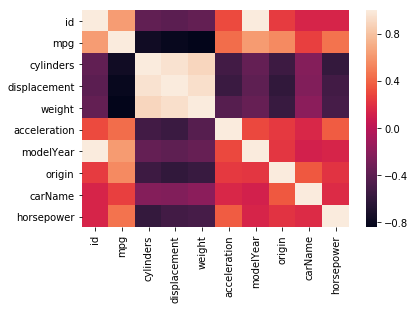

In [21]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = df_train.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [22]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pca = PCA()
X=df_train
X_reduced = pca.fit_transform(scale(X))
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

D:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.



array([ 53.27,  68.92,  79.15,  87.01,  93.28,  97.16,  99.04,  99.7 ,
        99.98, 100.01])

## Baseline (mean target_d)

In [384]:
#pred = df_train['TARGET_D'].median()
#base_mse = mean_squared_error(df_test['TARGET_D'], [pred for x in df_test['TARGET_D']])
#print("Baseline MSE: " + str(base_mse))
#print("RMSE: " + str(math.sqrt(base_mse)))

### Initialize Training data

In [81]:
df_vars = df_train.loc[:, df_train.columns != 'mpg']
df_vars = df_vars.loc[:, df_vars.columns != 'id']
df_class = df_train['mpg']
df_id = df_train['id']

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=test_set_ratio, random_state=0)

In [65]:
X_test

,cylinders,displacement,weight,acceleration,modelYear,origin,carName,horsepower
18,6,258.0,3410,15.1,78,1,3,7
169,8,318.0,4457,13.5,74,1,58,19
106,8,400.0,4997,14.0,73,1,32,19
92,8,260.0,3365,15.5,78,1,110,2
176,8,318.0,4135,13.5,72,1,126,19
183,4,79.0,1963,15.5,74,2,154,45
5,6,232.0,3288,15.5,71,1,8,0
139,4,140.0,2408,19.5,72,1,39,64
12,4,90.0,2085,21.7,80,2,161,35
160,4,97.0,1985,16.4,77,3,145,45


In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

df_vars_all = df_vars

scaler = StandardScaler()
df_vars_all = scaler.fit_transform(df_vars_all)

#reg = tree.DecisionTreeRegressor(min_samples_split=10)
reg = RandomForestRegressor(n_estimators=100)
#reg = linear_model.Ridge()
scores = cross_validate(reg, df_vars, df_class, cv=10, scoring='neg_mean_squared_error')
scores

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



{'fit_time': array([0.13006854, 0.12799835, 0.12799907, 0.12699819, 0.12707639,
        0.12699246, 0.12699795, 0.12892079, 0.12499881, 0.12499928]),
 'score_time': array([0.00792885, 0.00700021, 0.00799942, 0.00800014, 0.00800014,
        0.00699997, 0.0090003 , 0.0079999 , 0.00699997, 0.00800037]),
 'test_score': array([-15.5929582 , -13.8300241 ,  -1.4901823 ,  -4.48392705,
         -6.69348785,  -5.5013292 ,  -5.72342145,  -5.7134    ,
         -2.7662454 , -14.65091774]),
 'train_score': array([-0.97072597, -0.97901384, -1.10832413, -1.06863364, -1.10578021,
        -1.26345293, -1.06615068, -1.07784065, -1.07471536, -0.95039767])}

### Model fitting and sample testing

In [131]:
model = reg.fit(X_train, y_train)
model.score(X_test, y_test)

0.9340914248174444

In [132]:
model = reg.fit(df_vars, df_class)

### Final prediction

In [133]:
df_res = pd.DataFrame()
df_res['id'] = df_test['id']
df_res['mpg'] = pd.Series(model.predict(df_test.loc[:,df_test.columns!='id']))
df_res.head(10)

,id,mpg
0,219,31.244
1,322,32.814
2,260,21.163
3,168,27.260
4,97,15.369
5,223,17.151
6,367,21.769
7,239,28.555
8,206,27.410
9,92,13.125


### Export

In [134]:
export_file_name = result_folder + "mpg_rf.csv"
df_res.to_csv(export_file_name, index=False)

### Easy comparison

In [39]:
import traceback
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn import preprocessing
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, KDTree, BallTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

df_vars_all = df_train.loc[:, df_train.columns != 'mpg']
df_class = df_train['mpg']

scaler = StandardScaler()
df_vars_all = scaler.fit_transform(df_vars_all)

names = ["Linear", 
         "Ridge",
         "Elastic Net", 
         "PLS",
         "Decision Tree", 
         "Random Forest",
         "AdaBoost"]

classifiers = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20),
    RandomForestRegressor(n_estimators=100),
    AdaBoostRegressor()
]

cl_scores = {}
df_vars = df_vars_all
scoring = {'mse': 'neg_mean_squared_error',
          'mae': 'neg_median_absolute_error'}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars, df_class, cv=10, scoring=scoring, return_train_score=True)
        cl_scores[name] = scores
        for score in scoring:
            print(name,"--",score,"-- Training Set --", "Mean", scores['train_'+score].mean(), "-- Min", scores['train_'+score].min(), "-- Max", scores['train_'+score].max())
            print(name,"--",score,"-- Test Set --", "Mean", scores['test_'+score].mean(), "-- Min", scores['test_'+score].min(), "-- Max", scores['test_'+score].max())
    except:
        print("Regression failed for", name)
        traceback.print_exc()

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.



Linear -- mse -- Training Set -- Mean -9.342652945736454 -- Min -9.989239572711037 -- Max -8.495463817994425
Linear -- mse -- Test Set -- Mean -10.79226980577736 -- Min -19.05810919449117 -- Max -4.509683954887829
Linear -- mae -- Training Set -- Mean -2.0479187287161458 -- Min -2.191434121022212 -- Max -1.8494112048386295
Linear -- mae -- Test Set -- Mean -2.27257865512022 -- Min -2.9256332227825936 -- Max -1.6014776155555417
Ridge -- mse -- Training Set -- Mean -9.40785686995651 -- Min -10.045214208530803 -- Max -8.537602324687214
Ridge -- mse -- Test Set -- Mean -10.802247348104382 -- Min -19.818213062032513 -- Max -4.537243859195643
Ridge -- mae -- Training Set -- Mean -1.9948448222549466 -- Min -2.111084630444683 -- Max -1.8384606624528494
Ridge -- mae -- Test Set -- Mean -2.1730930130634407 -- Min -2.8434105759901005 -- Max -1.4742628780056517
Elastic Net -- mse -- Training Set -- Mean -13.379027962834371 -- Min -14.128348093431706 -- Max -11.969442850045985
Elastic Net -- mse --

### all features
Nearest Centroid -- Training Set -- Mean 0.7496791822186778 -- Min 0.7279005524861878 -- Max 0.7724039829302988
Nearest Centroid -- Test Set -- Mean 0.6628582456264915 -- Min 0.5873015873015873 -- Max 0.7543859649122807
Linear SVM -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Linear SVM -- Test Set -- Mean 0.9560670435070409 -- Min 0.9191919191919192 -- Max 1.0
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.9458952341983844 -- Min 0.9 -- Max 1.0
Naive Bayes -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Naive Bayes -- Test Set -- Mean 0.35593122949313594 -- Min 0.2727272727272727 -- Max 0.42857142857142855

In [40]:
import plotly.io as pio
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_mse']*-1,
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="MSE on Test Set (KDD Cup 1998)")
    
py.iplot(go.Figure(data=traces, layout=layout))
#pio.write_image(go.Figure(data=traces, layout=layout), 'kdd_boxplot.pdf')

In [55]:
from sklearn.feature_selection import f_regression
X = df_train.loc[:, df_train.columns != 'mpg']
y = df_train['mpg']

#Classifiers to be tested
names = ["Linear", "Ridge",
         "Elastic Net", "PLS",
        "Decision Tree", #"Random Forest",
        "AdaBoost"]

classifiers = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20),
    #RandomForestRegressor(n_estimators=100),
    AdaBoostRegressor()
]
cl_scores = {}
for name in names:
    cl_scores[name] = []
scoring = {'mse': 'neg_mean_squared_error',
          'mae': 'neg_median_absolute_error'}


for feature_count in [2,3,4,5,9]:
    X_selected = SelectKBest(f_regression, k=feature_count).fit_transform(X,y)
    print("----------------------------------")    
    print("Feature count=", feature_count)
    for name, clf in zip(names, classifiers):
        try:
            np.random.seed(32143421)
            scores = cross_validate(clf, X_selected, y, cv=10, scoring=scoring, return_train_score=True)
            cl_scores[name].append(scores)
            for score in scoring:
                print(name,"--",score,"-- Training Set --", "Mean", scores['train_'+score].mean(), "-- Min", scores['train_'+score].min(), "-- Max", scores['train_'+score].max())
                print(name,"--",score,"-- Test Set --", "Mean", scores['test_'+score].mean(), "-- Min", scores['test_'+score].min(), "-- Max", scores['test_'+score].max())
        except:
            print("Classification failed for", name)
            traceback.print_exc()

----------------------------------
Feature count= 2
Linear -- mse -- Training Set -- Mean -17.32404432048486 -- Min -18.227050672044538 -- Max -15.589028461838822
Linear -- mse -- Test Set -- Mean -18.459756374563284 -- Min -35.33979337625738 -- Max -9.866728664775081
Linear -- mae -- Training Set -- Mean -2.5935145777393513 -- Min -2.7054983474125436 -- Max -2.471669742120117
Linear -- mae -- Test Set -- Mean -2.648819481600297 -- Min -3.7440431824385723 -- Max -1.8696125032580149
Ridge -- mse -- Training Set -- Mean -17.324044320486816 -- Min -18.227050672045436 -- Max -15.589028461845043
Ridge -- mse -- Test Set -- Mean -18.459754977588574 -- Min -35.33977917109751 -- Max -9.866730225977872
Ridge -- mae -- Training Set -- Mean -2.593514068641178 -- Min -2.7054971603901485 -- Max -2.4716695195680707
Ridge -- mae -- Test Set -- Mean -2.6488190835278194 -- Min -3.7440434372847946 -- Max -1.86961078920082
Elastic Net -- mse -- Training Set -- Mean -17.32418781014382 -- Min -18.227195559

Decision Tree -- mse -- Training Set -- Mean -5.1621937558714475 -- Min -5.824109534883425 -- Max -4.22827612297533
Decision Tree -- mse -- Test Set -- Mean -11.838177137697233 -- Min -26.043580043662097 -- Max -3.480881301999753
Decision Tree -- mae -- Training Set -- Mean -1.2498742751486547 -- Min -1.3624999999999972 -- Max -1.1125000000000007
Decision Tree -- mae -- Test Set -- Mean -2.1667960949224487 -- Min -4.399999999999999 -- Max -1.0855555555555547
AdaBoost -- mse -- Training Set -- Mean -4.019615060092593 -- Min -4.773615059313151 -- Max -3.400900608311632
AdaBoost -- mse -- Test Set -- Mean -8.644820363543678 -- Min -18.270169737937895 -- Max -4.029945557572231
AdaBoost -- mae -- Training Set -- Mean -1.4179628180219386 -- Min -1.5375000000000014 -- Max -1.2592592592592595
AdaBoost -- mae -- Test Set -- Mean -1.6300895429026583 -- Min -2.0333333333333385 -- Max -1.201428571428571
----------------------------------
Feature count= 9
Linear -- mse -- Training Set -- Mean -9.34

In [59]:
names = ["Linear", "Ridge",
         "Elastic Net", "PLS",
        "Decision Tree", #"Random Forest",
        "AdaBoost"]
trace=[]

classifiers = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20),
    #RandomForestRegressor(n_estimators=100),
    AdaBoostRegressor()
]
feature_counts = [2,3,4,5,9]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_mse']:
            trace.append({'score': score, 'x':idx, 'name':feature_count , 'classifier':cl})
df_mpg = pd.DataFrame.from_dict(trace)

D:\Program_Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



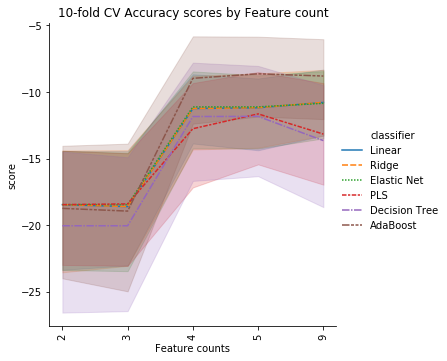

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_mpg)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count")
axes = plt.gca()
#axes.set_ylim([0.5,0.61])
#axes.set_xlim([0,len(feature_counts)])
plt.savefig('feature_cnt_eval_greenhouse.pdf')
plt.show()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_vars.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
trace = []
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
feature_counts = [1,2,5,10,20,30,40,50,100,500,1000,10000]#, "All"]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_score']:
            trace.append({'score': score, 'x':idx, 'name':feature_count, 'classifier':cl})
df_trace = pd.DataFrame.from_dict(trace)

E:\Python\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



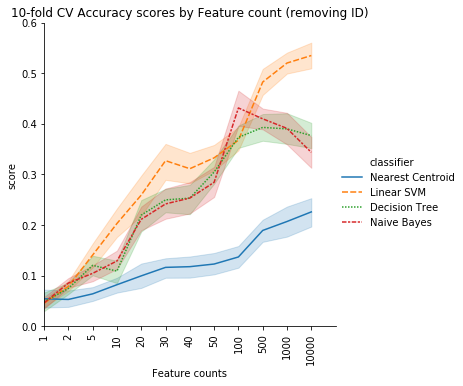

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_trace)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count (removing ID)")
axes = plt.gca()
axes.set_ylim([0.0,0.6])
axes.set_xlim([0,len(feature_counts)])
plt.savefig('feature_cnt_eval_wo_ID.pdf')
plt.show()

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'Class']
#df_vars_all = df_vars_all.drop('ID', axis=1)
df_class = df_train['Class']
selector = SelectKBest(chi2, k=1)
selector.fit(df_vars_all, df_class)
cols = selector.get_support(indices=True)
best_features = df_vars_all.columns[cols]
#df_vars = SelectKBest(chi2, k=1).fit_transform(df_vars_all, df_class)
best_features

Index(['ID'], dtype='object')

In [4]:
df_train.columns

Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       ...
       'V9992', 'V9993', 'V9994', 'V9995', 'V9996', 'V9997', 'V9998', 'V9999',
       'V10000', 'Class'],
      dtype='object', length=10002)

In [68]:
class_labels = sorted(df_train['Class'].unique(), key=lambda s: s.lower())
df_res = pd.DataFrame()
df_res['CONTROLN'] = df_test['CONTROLN']
df_res['TARGET_D'] = df_test['CONTROLN'].apply(lambda x: class_labels[(x-1)//30])
df_res.head(10)

,ID,class
0,656,Harp
1,949,Mark
2,255,CFH
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


In [69]:
export_file_name = result_folder + "kdd_prediction.csv"
df_res.to_csv(export_file_name, index=False)